<a href="https://colab.research.google.com/github/cku7808/Stacked-denoising-AE/blob/main/Stacked_Denoising_AE_Random_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

%matplotlib inline

In [38]:
train_data = datasets.MNIST("dataset", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST("dataset", train=False, download=True, transform=transforms.ToTensor())

In [39]:
print("number of train data :",len(train_data))
print("number of test data :",len(test_data))

number of train data : 60000
number of test data : 10000


In [40]:
train_data[0] # tuple 형태로 (tensor, label)로 구성

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [41]:
train_data[0][0].shape # (1,28,28)

torch.Size([1, 28, 28])

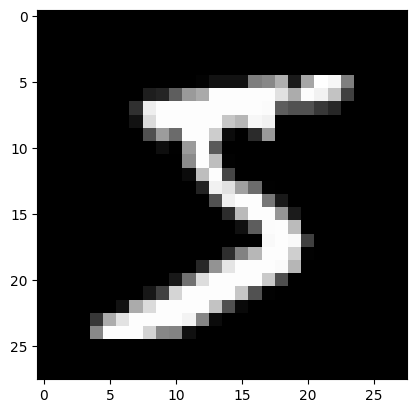

In [42]:
tmp_img, tmp_label = train_data[0]
plt.imshow(tmp_img.squeeze(), cmap="gray")

In [43]:
batch_size = 64
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

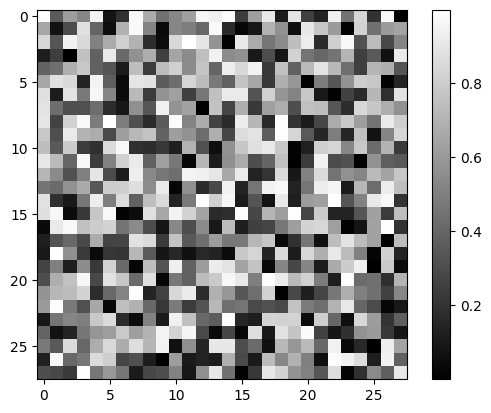

In [44]:
# 랜덤 노이즈 생성하기
noise = np.random.random((28,28))
plt.imshow(noise, cmap="gray")
plt.colorbar()

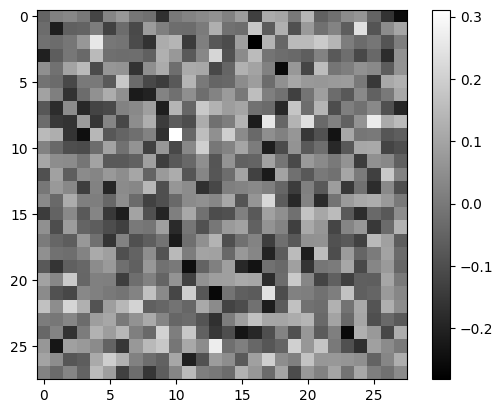

In [45]:
# 노이즈가 너무 강함 - 표준편차가 0.1인 가우시안(정규) 분포를 따르는 랜덤값 추출
noise = np.random.normal(0, 0.1, (28,28))
plt.imshow(noise, cmap="gray")
plt.colorbar()

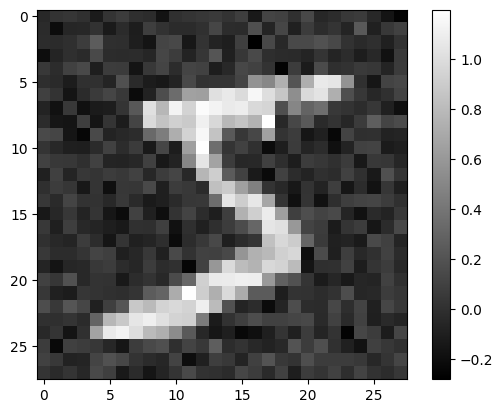

In [46]:
noise_ex = tmp_img.squeeze() + noise
plt.imshow(noise_ex, cmap="gray")
plt.colorbar()

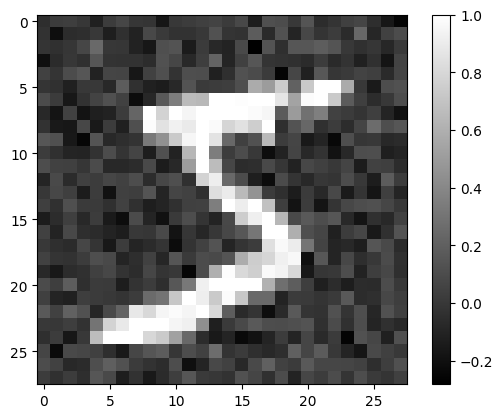

In [47]:
noise_ex[noise_ex > 1.0] = 1.0 # 1을 초과하는 경우 값을 1로 변경
plt.imshow(noise_ex, cmap="gray")
plt.colorbar()

In [48]:
# Stacked Denoising AE
class StackedDenoisingAE(nn.Module):
    def __init__(self, input_size, output_size):
        super(StackedDenoisingAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(input_size, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, output_size, kernel_size=3, stride=1, padding=0),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(output_size, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=0, output_padding=0),
            nn.Sigmoid() # 각 픽셀을 0-1 값으로 변환해야함 (grayscale이므로)
        )

    def forward(self, x):
        en_out_x = self.encoder(x)
        de_out_x = self.decoder(en_out_x)
        return de_out_x

In [49]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sdae_model = StackedDenoisingAE(1,64)
sdae_model = sdae_model.to(device)

In [50]:
criterion = nn.MSELoss()
optimizer = optim.Adam(sdae_model.parameters(), lr=0.00001)
# optimizer = optim.SGD(sdae_model.parameters(), lr=0.00001)
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(0)

epochs = 100
train_loss = []
for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss = 0

    for data in tqdm(train_loader, total=len(train_loader)):
        x, _ = data
        x = x.to(torch.float).to(device)
        noise = torch.randn_like(x) * 0.1  # x의 형상을 하는 평균0, 표준편차1인 정규분포에 0.1을 곱해 표준편차를 0.1로 만들기
        noise = noise.to(torch.float).to(device)
        noised_x = x + noise
        noised_x = torch.clamp(noised_x, 0, 1).to(torch.float).to(device)  # [0, 1] 범위로 클리핑 및 GPU로 올리기

        out_x = sdae_model(noised_x)
        loss = criterion(out_x, x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss.append(total_loss/len(train_loader))

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


100%|██████████| 938/938 [00:09<00:00, 100.46it/s]


Epoch 1/100, Loss: 0.0232


100%|██████████| 938/938 [00:10<00:00, 89.47it/s]


Epoch 2/100, Loss: 0.0122


100%|██████████| 938/938 [00:10<00:00, 86.89it/s]


Epoch 3/100, Loss: 0.0255


100%|██████████| 938/938 [00:10<00:00, 88.33it/s]


Epoch 4/100, Loss: 0.0185


100%|██████████| 938/938 [00:09<00:00, 99.90it/s] 


Epoch 5/100, Loss: 0.0070


100%|██████████| 938/938 [00:10<00:00, 89.11it/s] 


Epoch 6/100, Loss: 0.0066


100%|██████████| 938/938 [00:10<00:00, 90.40it/s] 


Epoch 7/100, Loss: 0.0052


100%|██████████| 938/938 [00:10<00:00, 91.36it/s]


Epoch 8/100, Loss: 0.0044


100%|██████████| 938/938 [00:09<00:00, 95.47it/s]


Epoch 9/100, Loss: 0.0064


100%|██████████| 938/938 [00:10<00:00, 88.87it/s] 


Epoch 10/100, Loss: 0.0064


100%|██████████| 938/938 [00:11<00:00, 83.69it/s] 


Epoch 11/100, Loss: 0.0035


100%|██████████| 938/938 [00:10<00:00, 88.64it/s]


Epoch 12/100, Loss: 0.0039


100%|██████████| 938/938 [00:09<00:00, 95.17it/s] 


Epoch 13/100, Loss: 0.0043


100%|██████████| 938/938 [00:10<00:00, 91.93it/s] 


Epoch 14/100, Loss: 0.0041


100%|██████████| 938/938 [00:10<00:00, 91.98it/s] 


Epoch 15/100, Loss: 0.0033


100%|██████████| 938/938 [00:09<00:00, 102.04it/s]


Epoch 16/100, Loss: 0.0029


100%|██████████| 938/938 [00:10<00:00, 93.19it/s] 


Epoch 17/100, Loss: 0.0028


100%|██████████| 938/938 [00:10<00:00, 91.08it/s] 


Epoch 18/100, Loss: 0.0034


100%|██████████| 938/938 [00:10<00:00, 92.62it/s]


Epoch 19/100, Loss: 0.0021


100%|██████████| 938/938 [00:09<00:00, 101.54it/s]


Epoch 20/100, Loss: 0.0019


100%|██████████| 938/938 [00:10<00:00, 92.19it/s] 


Epoch 21/100, Loss: 0.0025


100%|██████████| 938/938 [00:10<00:00, 91.95it/s] 


Epoch 22/100, Loss: 0.0024


100%|██████████| 938/938 [00:09<00:00, 95.89it/s]


Epoch 23/100, Loss: 0.0020


100%|██████████| 938/938 [00:09<00:00, 97.47it/s] 


Epoch 24/100, Loss: 0.0016


100%|██████████| 938/938 [00:10<00:00, 92.51it/s] 


Epoch 25/100, Loss: 0.0022


100%|██████████| 938/938 [00:10<00:00, 91.77it/s] 


Epoch 26/100, Loss: 0.0022


100%|██████████| 938/938 [00:09<00:00, 100.29it/s]


Epoch 27/100, Loss: 0.0018


100%|██████████| 938/938 [00:10<00:00, 91.60it/s] 


Epoch 28/100, Loss: 0.0016


100%|██████████| 938/938 [00:10<00:00, 91.53it/s] 


Epoch 29/100, Loss: 0.0028


100%|██████████| 938/938 [00:10<00:00, 91.57it/s]


Epoch 30/100, Loss: 0.0018


100%|██████████| 938/938 [00:09<00:00, 102.64it/s]


Epoch 31/100, Loss: 0.0018


100%|██████████| 938/938 [00:10<00:00, 91.17it/s] 


Epoch 32/100, Loss: 0.0015


100%|██████████| 938/938 [00:10<00:00, 92.40it/s] 


Epoch 33/100, Loss: 0.0014


100%|██████████| 938/938 [00:09<00:00, 94.69it/s]


Epoch 34/100, Loss: 0.0021


100%|██████████| 938/938 [00:09<00:00, 98.78it/s] 


Epoch 35/100, Loss: 0.0018


100%|██████████| 938/938 [00:10<00:00, 91.57it/s] 


Epoch 36/100, Loss: 0.0016


100%|██████████| 938/938 [00:10<00:00, 92.07it/s]


Epoch 37/100, Loss: 0.0014


100%|██████████| 938/938 [00:09<00:00, 99.60it/s]


Epoch 38/100, Loss: 0.0015


100%|██████████| 938/938 [00:09<00:00, 94.13it/s]


Epoch 39/100, Loss: 0.0022


100%|██████████| 938/938 [00:10<00:00, 90.89it/s] 


Epoch 40/100, Loss: 0.0015


100%|██████████| 938/938 [00:10<00:00, 91.71it/s]


Epoch 41/100, Loss: 0.0014


100%|██████████| 938/938 [00:09<00:00, 99.45it/s]


Epoch 42/100, Loss: 0.0015


100%|██████████| 938/938 [00:10<00:00, 92.53it/s]


Epoch 43/100, Loss: 0.0015


100%|██████████| 938/938 [00:10<00:00, 90.90it/s]


Epoch 44/100, Loss: 0.0015


100%|██████████| 938/938 [00:10<00:00, 92.20it/s]


Epoch 45/100, Loss: 0.0016


100%|██████████| 938/938 [00:09<00:00, 100.72it/s]


Epoch 46/100, Loss: 0.0014


100%|██████████| 938/938 [00:10<00:00, 91.31it/s]


Epoch 47/100, Loss: 0.0014


100%|██████████| 938/938 [00:11<00:00, 79.98it/s] 


Epoch 48/100, Loss: 0.0018


100%|██████████| 938/938 [00:09<00:00, 96.64it/s]


Epoch 49/100, Loss: 0.0013


100%|██████████| 938/938 [00:09<00:00, 95.00it/s] 


Epoch 50/100, Loss: 0.0012


100%|██████████| 938/938 [00:10<00:00, 91.33it/s] 


Epoch 51/100, Loss: 0.0014


100%|██████████| 938/938 [00:10<00:00, 89.90it/s] 


Epoch 52/100, Loss: 0.0015


100%|██████████| 938/938 [00:09<00:00, 98.88it/s]


Epoch 53/100, Loss: 0.0012


100%|██████████| 938/938 [00:10<00:00, 92.28it/s]


Epoch 54/100, Loss: 0.0012


100%|██████████| 938/938 [00:10<00:00, 91.76it/s]


Epoch 55/100, Loss: 0.0013


100%|██████████| 938/938 [00:10<00:00, 92.13it/s]


Epoch 56/100, Loss: 0.0015


100%|██████████| 938/938 [00:09<00:00, 98.69it/s] 


Epoch 57/100, Loss: 0.0014


100%|██████████| 938/938 [00:10<00:00, 89.26it/s]


Epoch 58/100, Loss: 0.0011


100%|██████████| 938/938 [00:10<00:00, 89.74it/s]


Epoch 59/100, Loss: 0.0012


100%|██████████| 938/938 [00:10<00:00, 90.64it/s]


Epoch 60/100, Loss: 0.0013


100%|██████████| 938/938 [00:09<00:00, 100.32it/s]


Epoch 61/100, Loss: 0.0015


100%|██████████| 938/938 [00:10<00:00, 90.43it/s] 


Epoch 62/100, Loss: 0.0013


100%|██████████| 938/938 [00:10<00:00, 91.64it/s] 


Epoch 63/100, Loss: 0.0016


100%|██████████| 938/938 [00:10<00:00, 93.17it/s]


Epoch 64/100, Loss: 0.0014


100%|██████████| 938/938 [00:09<00:00, 99.93it/s] 


Epoch 65/100, Loss: 0.0012


100%|██████████| 938/938 [00:10<00:00, 91.70it/s] 


Epoch 66/100, Loss: 0.0015


100%|██████████| 938/938 [00:10<00:00, 92.61it/s] 


Epoch 67/100, Loss: 0.0010


100%|██████████| 938/938 [00:09<00:00, 96.52it/s]


Epoch 68/100, Loss: 0.0011


100%|██████████| 938/938 [00:09<00:00, 96.33it/s] 


Epoch 69/100, Loss: 0.0010


100%|██████████| 938/938 [00:10<00:00, 92.01it/s] 


Epoch 70/100, Loss: 0.0010


100%|██████████| 938/938 [00:10<00:00, 91.95it/s] 


Epoch 71/100, Loss: 0.0011


100%|██████████| 938/938 [00:09<00:00, 98.65it/s]


Epoch 72/100, Loss: 0.0012


100%|██████████| 938/938 [00:09<00:00, 93.92it/s] 


Epoch 73/100, Loss: 0.0013


100%|██████████| 938/938 [00:10<00:00, 91.95it/s]


Epoch 74/100, Loss: 0.0011


100%|██████████| 938/938 [00:10<00:00, 91.04it/s]


Epoch 75/100, Loss: 0.0011


100%|██████████| 938/938 [00:09<00:00, 100.27it/s]


Epoch 76/100, Loss: 0.0010


100%|██████████| 938/938 [00:10<00:00, 91.21it/s]


Epoch 77/100, Loss: 0.0011


100%|██████████| 938/938 [00:10<00:00, 91.81it/s] 


Epoch 78/100, Loss: 0.0014


100%|██████████| 938/938 [00:10<00:00, 92.90it/s]


Epoch 79/100, Loss: 0.0012


100%|██████████| 938/938 [00:09<00:00, 98.81it/s] 


Epoch 80/100, Loss: 0.0010


100%|██████████| 938/938 [00:10<00:00, 90.21it/s]


Epoch 81/100, Loss: 0.0010


100%|██████████| 938/938 [00:10<00:00, 90.22it/s] 


Epoch 82/100, Loss: 0.0010


100%|██████████| 938/938 [00:11<00:00, 80.30it/s]


Epoch 83/100, Loss: 0.0008


100%|██████████| 938/938 [00:09<00:00, 96.48it/s] 


Epoch 84/100, Loss: 0.0011


100%|██████████| 938/938 [00:10<00:00, 89.38it/s]


Epoch 85/100, Loss: 0.0012


100%|██████████| 938/938 [00:10<00:00, 90.61it/s]


Epoch 86/100, Loss: 0.0013


100%|██████████| 938/938 [00:10<00:00, 89.08it/s]


Epoch 87/100, Loss: 0.0011


100%|██████████| 938/938 [00:09<00:00, 98.39it/s]


Epoch 88/100, Loss: 0.0009


100%|██████████| 938/938 [00:10<00:00, 88.25it/s]


Epoch 89/100, Loss: 0.0010


100%|██████████| 938/938 [00:10<00:00, 89.40it/s]


Epoch 90/100, Loss: 0.0010


100%|██████████| 938/938 [00:10<00:00, 88.32it/s]


Epoch 91/100, Loss: 0.0012


100%|██████████| 938/938 [00:09<00:00, 98.24it/s]


Epoch 92/100, Loss: 0.0010


100%|██████████| 938/938 [00:10<00:00, 89.78it/s]


Epoch 93/100, Loss: 0.0010


100%|██████████| 938/938 [00:10<00:00, 90.55it/s]


Epoch 94/100, Loss: 0.0012


100%|██████████| 938/938 [00:10<00:00, 90.24it/s]


Epoch 95/100, Loss: 0.0015


100%|██████████| 938/938 [00:09<00:00, 99.46it/s]


Epoch 96/100, Loss: 0.0012


100%|██████████| 938/938 [00:10<00:00, 90.45it/s] 


Epoch 97/100, Loss: 0.0012


100%|██████████| 938/938 [00:10<00:00, 89.95it/s]


Epoch 98/100, Loss: 0.0013


100%|██████████| 938/938 [00:10<00:00, 89.37it/s]


Epoch 99/100, Loss: 0.0014


100%|██████████| 938/938 [00:09<00:00, 100.06it/s]

Epoch 100/100, Loss: 0.0010


Text(0, 0.5, 'Loss')

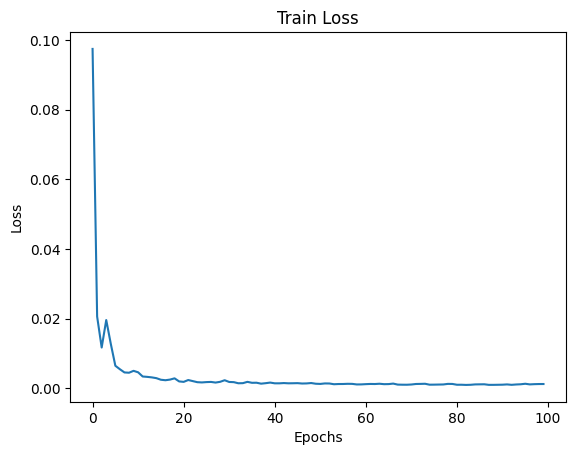

In [51]:
# train loss graph
plt.title("Train Loss")
plt.plot(train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')


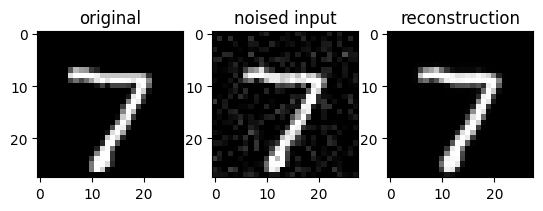

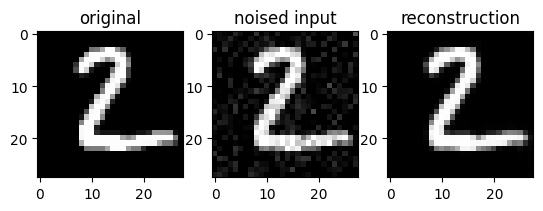

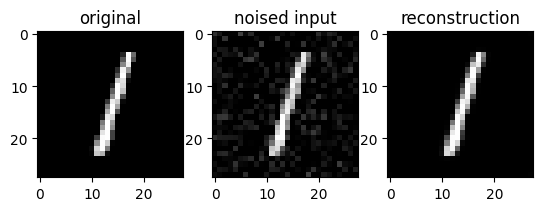

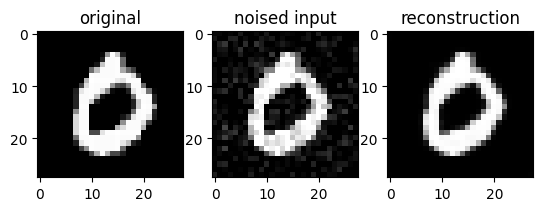

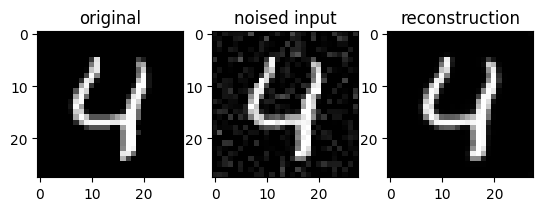

In [52]:
# test
sdae_model.eval()
for i, data in enumerate(test_loader):
    if i < 5:
        x, _ = data
        x = x.to(device)  # GPU로 이동

        noise = torch.randn_like(x) * 0.1  # x의 형상을 하는 평균0, 표준편차1인 정규분포에 0.1을 곱해 표준편차를 0.1로 만들기
        noise = noise.to(torch.float).to(device)
        noised_x = x + noise
        noised_x = torch.clamp(noised_x, 0, 1).to(torch.float).to(device)

        out_x = sdae_model(noised_x).cpu().detach()  # 모델 결과를 CPU로 옮기기

        fig = plt.figure()
        rows = 1
        cols = 3
        ax1 = fig.add_subplot(rows, cols, 1)
        ax1.imshow(x.cpu().numpy().squeeze(), cmap="gray")  # 이미지를 CPU로 옮기기
        ax1.set_title("original")

        ax2 = fig.add_subplot(rows, cols, 2)
        ax2.imshow(noised_x.cpu().numpy().squeeze(), cmap="gray")  # 이미지를 CPU로 옮기기
        ax2.set_title("noised input")

        ax3 = fig.add_subplot(rows, cols, 3)
        ax3.imshow(out_x.numpy().squeeze(), cmap="gray")  # 이미지를 CPU로 옮기기
        ax3.set_title("reconstruction")

        plt.show()


In [53]:
sdae_model.eval()
test_loss = 0
for i, data in enumerate(test_loader):
  x, _ = data
  x = x.to(device)  # GPU로 이동

  noise = torch.randn_like(x) * 0.1  # x의 형상을 하는 평균0, 표준편차1인 정규분포에 0.1을 곱해 표준편차를 0.1로 만들기
  noise = noise.to(torch.float).to(device)
  noised_x = x + noise
  noised_x = torch.clamp(noised_x, 0, 1).to(torch.float).to(device)

  out_x = sdae_model(noised_x)  # 모델 결과를 CPU로 옮기기
  test_loss += criterion(x,out_x)
test_loss = test_loss/len(test_loader)
print("Test Loss :",test_loss)

Test Loss : tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
